In [45]:
import numpy as np

euler_cube = np.load('./output/euler_cube.npy')
coord_cube = np.load('./output/coord_cube.npy')
Nb_cube = np.load('./output/Nb_cube.npy')
Sn_cube = np.load('./output/Sn_cube.npy')

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation


euler_points = euler_cube.reshape(euler_cube.shape[0]*euler_cube.shape[1]*euler_cube.shape[2],euler_cube.shape[3])



coordinates = coord_cube.reshape(coord_cube.shape[0]*coord_cube.shape[1]*coord_cube.shape[2],coord_cube.shape[3])


#EBSD_points = np.append(coordinates,euler_points,axis=-1)

nonzero = list(not(np.array_equal(euler_points[i,:],np.array((0.0,0.0,0.0)))) for i in range(euler_points.shape[0]))
coordinates = coordinates[nonzero]
euler_points = euler_points[nonzero]

rotations = Rotation.from_euler('XZX',euler_points)

del euler_points

#coordinates = np.append(coordinates,[[100,100,100]],axis=0)
np.random.seed(0)
subsample = np.random.randint(0,coordinates.shape[0],size=80000)

rotations = rotations[subsample]
coordinates = coordinates[subsample]

#plt.scatter(euler_points[:,0],euler_points[:,1],c=euler_points[:,2])

In [47]:
from scipy.spatial import Voronoi

vor = Voronoi(coordinates)

In [48]:
from scipy.sparse import csr_array

vertices = vor.vertices

infinite_point = np.array((100.0,100.0,100.0))
vertices = np.concatenate((vertices,infinite_point[None,:]),axis=0)

edges = []
ridge_edges = []
i = 0

for ridge in vor.ridge_vertices:
    new_ridge = []
    for (vert1, vert2) in zip(ridge,ridge[1:]+ridge[:1]):
        """create new edge"""
        new_edge = [vert1,vert2]
        edges.append(new_edge)

        """add edge to ridge"""
        new_ridge.append(i)
        i += 1

    ridge_edges.append(new_ridge)

edges, inverse = np.unique(np.array(edges),axis=0,return_inverse=True)
ridge_edges = [[inverse[j] for j in ridge_edges[i]] for i in range(len(ridge_edges))]







In [49]:
region_ridges = [[] for _ in range(len(vor.regions))]

for ridge_ind, ridge in enumerate(vor.point_region[vor.ridge_points]):
    for region_ind in ridge:
        region_ridges[region_ind].append(ridge_ind)

In [50]:
T_VE = csr_array((vor.vertices.shape[0],edges.shape[0]),dtype='bool')
T_EF = csr_array((edges.shape[0],len(ridge_edges)),dtype='bool')
T_FD = csr_array((len(ridge_edges),len(vor.regions)),dtype='bool')

In [51]:
X,Y = np.indices(edges.shape)

T_VE[edges.flatten(),X.flatten()] = True

# for i, edge in enumerate(edges):
#     T_VE[edge[0],i] = True
#     T_VE[edge[1],i] = True

c:\Users\viklund\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [52]:
ridge_ind = np.repeat(np.arange(len(ridge_edges)),[len(ridge_edges[i]) for i in range(len(ridge_edges))])
edge_ind = [edge for ridge in ridge_edges for edge in ridge]

T_EF[edge_ind,ridge_ind] = True

# for ridge_ind, ridge in enumerate(ridge_edges):
#     for edge in ridge:
#         T_EF[edge,ridge_ind] = True

In [53]:
ridge_ind = [ridge for region in region_ridges for ridge in region]
region_ind = np.repeat(np.arange(len(region_ridges)),[len(region_ridges[i]) for i in range(len(region_ridges))])

T_FD[ridge_ind,region_ind] = True

# for face in np.arange(0,vor.ridge_points.shape[0]):
#     for domain in vor.point_region[vor.ridge_points[face,:]]:
#         T_FD[face,domain] = True

In [54]:
"""Find the vacuum interface"""
from skimage.measure import marching_cubes

total_xray_cube = Nb_cube + Sn_cube

# plt.hist(total_xray_cube.flatten())

verts, faces, normals, values = marching_cubes(total_xray_cube,120000,spacing=(0.1,0.1,0.1))

In [55]:
def save_obj(filepath, verts, faces):
    file = open(filepath, 'w')
    for vertex in verts:
        file.write(f"v {vertex[0]} {vertex[1]} {vertex[2]}\n")

    for face in faces:
        file.write(f"f ")
        for ind in face:
            file.write(f"{ind+1} ")
        file.write("\n")  

    file.close()

In [56]:
save_obj('output/sample_surface.obj',verts,faces)

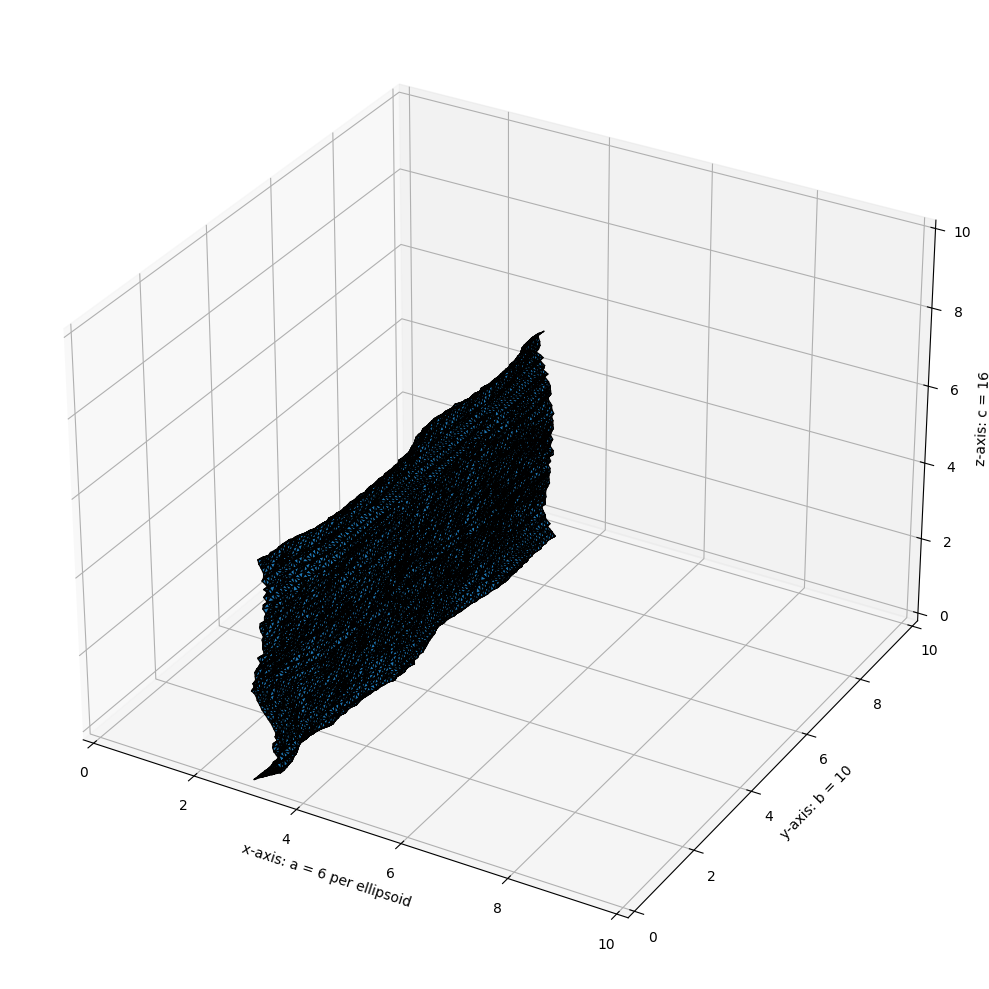

In [57]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 10)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 10)  # b = 10
ax.set_zlim(0, 10)  # c = 16

plt.tight_layout()
plt.show()

In [58]:
"""add bounding box"""

'add bounding box'

In [59]:
"""calculate intersections between domain faces and bounding surface"""

'calculate intersections between domain faces and bounding surface'

In [60]:
"""create new faces and update intersecting domains"""

'create new faces and update intersecting domains'

In [61]:
misorientations = rotations[vor.ridge_points[:,0]] * rotations[vor.ridge_points[:,1]].inv()
misorientations = np.linalg.norm(misorientations.as_rotvec(),axis=-1)

# GBs = [i for (i,v) in zip(vor.ridge_points,(misorientations > 0.1)) if v]
# nonGBs = [i for (i,v) in zip(vor.ridge_points,(misorientations < 0.1)) if v]

# GBs = vor.point_region[vor.ridge_points[misorientations > 0.1]]
# nonGBs = vor.point_region[vor.ridge_points[misorientations < 0.1]]

GBs = np.arange(0,vor.ridge_points.shape[0])[misorientations > 0.1]
nonGBs = np.arange(0,vor.ridge_points.shape[0])[misorientations <= 0.1]

In [62]:
A_DGB = csr_array((T_FD.shape[1],T_FD.shape[1]))
T_FDGB = csr_array(T_FD.shape)

T_FDGB = T_FD * (misorientations > 0.1)[:,None]
T_FDGB.eliminate_zeros()

A_DGB = T_FDGB.T @ T_FDGB
A_DGB.eliminate_zeros()
A_D = T_FD.T @ T_FD
A_D.eliminate_zeros()
A_DnonGB = A_D - A_DGB
A_DnonGB.eliminate_zeros()

In [63]:
from scipy.sparse.csgraph import breadth_first_tree

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)


remaining_regions = vor.point_region
grains = []

while remaining_regions.shape[0] > 0:
    csr_grain = breadth_first_tree(A_DnonGB,remaining_regions[0],directed=False)

    csr_grain = csr_grain.tocoo()

    grain_regions = np.unique(np.concatenate((csr_grain.coords[0],csr_grain.coords[1],remaining_regions[0,None])))

    remaining_regions = np.setdiff1d(remaining_regions,grain_regions,assume_unique=True)

    grains.append(grain_regions)

    # grain_ids = [vor.regions[v] for v in grain_regions]
    # color = np.random.rand(3,)

    # ax = fig.axes[0]

    # for i, regionid in enumerate(grain_ids):

    #     # print(f"point index: {i}")
    #     # print(f"region ID: {regionid}")
        
    #     if -1 not in regionid:

    #         vertices = vor.vertices[regionid]
    #         vertices = np.asarray(vertices)
    #         ax.fill(vertices[:,0],vertices[:,1],facecolor=color)


In [64]:
T_PD = csr_array((len(vor.point_region),len(vor.regions)),dtype='bool')

point_ind = np.arange((len(vor.point_region)))
domain_ind = vor.point_region

T_PD[point_ind,domain_ind] = True


In [65]:
T_DG = csr_array((len(vor.regions),len(grains)),dtype='bool')

grain_ind, domain_ind = np.array([[i,domain] for i, grain in enumerate(grains) for domain in grain]).T

T_DG[domain_ind,grain_ind] = True

# for i, grain in enumerate(grains):
#     for domain in grain:
#         T_DG[domain,i] = True

In [66]:
T_DG

<64214x304 sparse array of type '<class 'numpy.bool_'>'
	with 64213 stored elements in Compressed Sparse Row format>

In [67]:
2390081581/(173976*173976)

0.07896489134260523

In [68]:
B_D = T_DG @ T_DG.T
B_D.eliminate_zeros()

In [69]:
T_FG = csr_array((T_FD.shape[0],T_DG.shape[1]),dtype='bool')

T_FG = T_FD@(B_D * A_DGB)@T_DG * (T_FD@T_DG)
T_FG.eliminate_zeros()

In [70]:
T_VG = T_VE@T_EF@T_FG
T_VG.eliminate_zeros()

In [71]:
GB_vertices = [vor.ridge_vertices[face] if -1 not in vor.ridge_vertices[face] else [] for face in T_FG[:,[1]].tocoo().coords[0]]

In [72]:
GB_vert_coords = [vertices[GB_vertices[face]] for face in range(len(GB_vertices))]

In [73]:
for face in GB_vert_coords:
    for vert in face:
        if np.any(vert > 10.0):
            GB_vert_coords.remove(face)

c:\Users\viklund\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\viklund\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


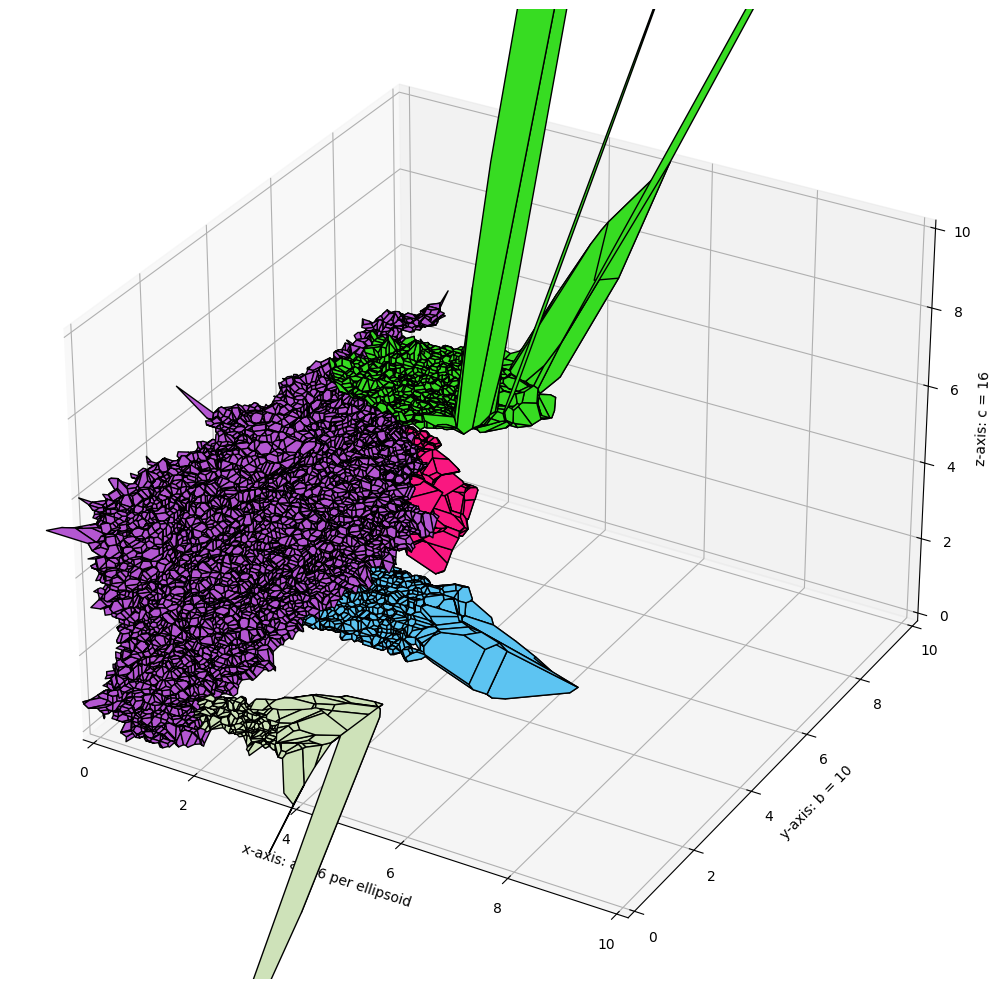

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from copy import deepcopy

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(5):
    GB_vertices = [vor.ridge_vertices[face] if -1 not in vor.ridge_vertices[face] else [] for face in T_FG[:,[i]].tocoo().coords[0]]
    GB_vert_coords = [vertices[GB_vertices[face]] for face in range(len(GB_vertices))]
    # temp = []
    # for i, face in enumerate(GB_vert_coords):
    #     for vert in face:
    #         if np.any((vert < 10.0)) and np.any((vert > 0.0)):
    #             temp.append(face)

    # GB_vert_coords = temp

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(GB_vert_coords)
    
    color = np.random.rand((3))
    mesh.set_color(color)
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 10)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 10)  # b = 10
ax.set_zlim(0, 10)  # c = 16

plt.tight_layout()
plt.show()

In [96]:
for i in range(T_FG.shape[1]):
    if T_DG[:,[i]].tocoo().coords[0].shape[0] > 100:

        GB_vertices = [vor.ridge_vertices[face] if -1 not in vor.ridge_vertices[face] else [] for face in T_FG[:,[i]].tocoo().coords[0]]
        GB_vert_coords = [vertices[GB_vertices[face]] for face in range(len(GB_vertices))]

        faces = GB_vertices
        verts = vertices

        save_obj(f'output/grain{i}.obj',verts,faces)

In [ ]:
def ray_plane_intersection(ray_point,direction,plane_point,normal):
    t = np.dot(plane_point - ray_point,normal)/np.dot(direction,normal)
    intersection = ray_point + t*direction
    return intersection

def project_to_plane(points,plane_point,normal):

    trans_matrix = np.array((normal,points[0,:] - plane_point,points[1,:] - plane_point))
    return trans_matrix

def segment_intersection(x0,x1,p0,p1):
    s0 = x1-x0
    s1 = p1-p0
    v = p0-x0

    cross = np.cross(s0,s1)

    u = np.cross(v,s0)/cross
    t = np.cross(v,s1)/cross

    intersection = p0 + np.stack([t,t],axis=-1)*s1

    return intersection * (np.greater_equal(u,0) * np.greater_equal(t,0) * np.less_equal(u,1) * np.less_equal(t,1))[...,None]
